# **Hospital Readmission Prediction - Feature Engineering**

This notebook focuses on feature engineering for the hospital readmission prediction model. We'll transform raw features into more informative ones and prepare the data for modeling.

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import warnings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

## 1. **Load the Data**

In [226]:
data = pd.read_csv('diabetic_data.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# 2. **Basic Preprocessing**

In [227]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 50)


In [178]:
data['encounter_count'] = data.groupby('patient_nbr')['encounter_id'].transform('count')


##Removed columns with over 40% missing data.

---



In [228]:
import numpy as np
import pandas as pd
data = data.replace('?', np.nan)
missing_threshold = 0.4
high_missing = data.columns[data.isnull().mean() > missing_threshold]
print("Columns with more than 40% missing values:")
print(high_missing.tolist())
data.drop(columns=high_missing, inplace=True)

Columns with more than 40% missing values:
['weight', 'medical_specialty', 'max_glu_serum', 'A1Cresult']


In [229]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 46)


In [230]:
missing_count = data.isna().sum()
missing_percent = (data.isna().mean() * 100).round(2)
missing_info = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_percent
})
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
print(missing_info)

            Missing Count  Missing %
payer_code          40256      39.56
race                 2273       2.23
diag_3               1423       1.40
diag_2                358       0.35
diag_1                 21       0.02


##Missing values in the 'payer_code' and 'race' columns have been imputed using the mode.

In [231]:
for col in ['payer_code', 'race']:
    mode_val = data[col].mode()[0]
    data[col] = data[col].fillna(mode_val)

In [232]:
cols = ['diag_1', 'diag_2', 'diag_3']
total_nans = data[cols].isna().sum().sum()
print("Total NaN values in diag_1, diag_2, and diag_3:", total_nans)

Total NaN values in diag_1, diag_2, and diag_3: 1802


##Missing values in the three diagnosis columns were imputed with '00'.

In [233]:
cols = ['diag_1', 'diag_2', 'diag_3']
data[cols] = data[cols].fillna('Unknown')

In [234]:
cols = ['diag_1', 'diag_2', 'diag_3']
total_nans = data[cols].isna().sum().sum()
print("Total NaN values in diag_1, diag_2, and diag_3:", total_nans)

Total NaN values in diag_1, diag_2, and diag_3: 0


# 3. **Feature Engineering**

##Created a 'VisitType' feature by classifying visit patterns from inpatient, outpatient, and emergency columns. Dropped original columns after transformation.

In [ ]:
import pandas as pd
def classify_visit(row):
    inpatient = row['number_inpatient']
    outpatient = row['number_outpatient']
    emergency = row['number_emergency']

    if emergency > 0:
        return 'emergency'
    elif inpatient > 10:
        return 'high_inpatient'
    elif inpatient > 0:
        return 'low_inpatient'
    elif outpatient >= 19:
        return 'high_outpatient_rate'
    elif outpatient > 0:
        return 'low_outpatient_rate'
    else:
        return 'novisit'
data['VisitType'] = data.apply(classify_visit, axis=1)
data.drop(['number_inpatient', 'number_outpatient', 'number_emergency'], axis=1, inplace=True)

**This code maps numeric admission_type_id values to readable category labels (like 'Emergency', 'Elective', etc.) using a dictionary, creates a new column admission_type with these labels, and then drops the original admission_type_id column.**

In [235]:
# Map admission_type_id to descriptive labels
admission_type_map = {
    1: 'Emergency',
    2: 'Urgent',
    3: 'Elective',
    4: 'Newborn',
    5: 'Unknown',  # Previously 'Not Available'
    6: 'Unknown',  # Previously 'NULL'
    7: 'Trauma Center',
    8: 'Unknown'   # Previously 'Not Mapped'
}

# Apply mapping and drop original column
data['admission_type'] = data['admission_type_id'].map(admission_type_map)
data.drop(columns=['admission_type_id'], inplace=True)


In [237]:
data['admission_group'] = data['admission_type'].map({
    'Emergency': 'Unplanned',
    'Urgent': 'Unplanned',
    'Elective': 'Planned',
    'Unknown': 'Unknown',  # includes NULL, Not Available
})


**This line creates a new column expiration_ind that flags whether a patient's discharge disposition indicates death (based on specific ID values). It assigns 1 if true (i.e., patient expired) and 0 otherwise.**

In [239]:
data['expiration_ind'] = data['discharge_disposition_id'].isin([11,13,14,19,20,21]).astype('int')

 discharge_disposition_id column

**This code maps the discharge_disposition_id values to broader categories (like 'Home', 'Transferred Hospital', etc.) using discharge_group_map, then creates a new column discharge_group with these values. It finally drops the original discharge_disposition_id column for simplification.**

In [186]:
discharge_group_map = {
    1: 'Home',
    6: 'Home',
    8: 'Home',

    3: 'SNF/ICF/Rehab',
    4: 'SNF/ICF/Rehab',
    22: 'SNF/ICF/Rehab',
    23: 'SNF/ICF/Rehab',
    24: 'SNF/ICF/Rehab',
    15: 'SNF/ICF/Rehab',

    2: 'Transferred Hospital',
    5: 'Transferred Hospital',
    27: 'Transferred Hospital',
    28: 'Transferred Hospital',
    29: 'Transferred Hospital',
    30: 'Transferred Hospital',

    12: 'Outpatient Follow-up',
    16: 'Outpatient Follow-up',
    17: 'Outpatient Follow-up',

    9: 'Inpatient Readmit',
    7: 'Left AMA',

    18: 'Unknown/Invalid',
    25: 'Unknown/Invalid',
    26: 'Unknown/Invalid'
}

# Apply mapping
data['discharge_group'] = data['discharge_disposition_id'].map(discharge_group_map)

data.drop(['discharge_disposition_id'], axis=1, inplace=True)

**This code maps the admission_source_id values to descriptive labels (such as 'Physician Referral', 'Emergency Room', etc.) using the admission_source_id dictionary. It then creates a new column admission_source_grouped with these mapped values and drops the original admission_source_id column.**

In [187]:
admission_source_id = { 1 : 'Physician Referral'
, 2 : 'Clinic Referral'
, 3 : 'HMO Referral'
, 4 : 'Transfer from a hospital'
, 5 : 'Transfer from a Skilled Nursing Facility (SNF)'
, 6 : 'Transfer from another health care facility'
, 7 : 'Emergency Room'
, 8 : 'Court/Law Enforcement'
, 9 :  'Not Available'
, 10 : 'Transfer from critial access hospital'
, 11 : 'Normal Delivery'
, 12 : 'Premature Delivery'
, 13 : 'Sick Baby'
, 14 : 'Extramural Birth'
, 15 : 'Not Available'
, 17 : 'NULL'
, 18 : 'Transfer From Another Home Health Agency'
, 19 : 'Readmission to Same Home Health Agency'
, 20 : 'Not Mapped'
, 21 : 'Unknown/Invalid'
, 22 : 'Transfer from hospital inpt/same fac reslt in a sep claim'
, 23 : 'Born inside this hospital'
, 24 : 'Born outside this hospital'
, 25 : 'Transfer from Ambulatory Surgery Center'
, 26 : 'Transfer from Hospice'
                      }
# Apply mapping
data['admission_source_grouped'] = data['admission_source_id'].map(admission_source_id)
data.drop(['admission_source_id'], axis=1, inplace=True)

In [188]:
data['is_clinic_or_transfer'] = data['admission_source_grouped'].isin([
    'Clinic Referral',
    'Transfer from a hospital',
    'Transfer from another health care facility'
]).astype(int)


**This code creates multiple new indicator columns based on the admission_type and discharge_group columns, grouping them into categories like 'Emergency', 'Elective', and 'Home' vs 'Transferred Hospital'. It then aggregates the counts of these grouped categories at the patient level (using groupby on patient_nbr), creating columns like mb_admission_grp_1_ct and mb_discharge_grp_1_ct to capture the frequency of these categories for each patient.**

In [189]:
data['admission_grp_1_ind'] = data['admission_type'].isin(['Emergency', 'Unknown']).astype(int)
data['admission_grp_2_ind'] = data['admission_type'].isin(['Elective', 'Trauma Center']).astype(int)

data['discharge_grp_1_ind'] = data['discharge_group'].isin([
    'Home', 'SNF/ICF/Rehab', 'Unknown/Invalid'
]).astype(int)

data['discharge_grp_2_ind'] = data['discharge_group'].isin([
    'Left AMA', 'Transferred Hospital', 'Inpatient Readmit', 'Outpatient Follow-up'
]).astype(int)

data['admission_type_ind'] = data['admission_source_grouped'].isin([
    'Clinic Referral', 'Transfer from a hospital', 'Transfer from another health care facility'
]).astype(int)


In [190]:
data['mb_admission_grp_1_ct'] = data.groupby('patient_nbr')['admission_grp_1_ind'].transform('sum')
data['mb_admission_grp_2_ct'] = data.groupby('patient_nbr')['admission_grp_2_ind'].transform('sum')
data['mb_discharge_grp_1_ct'] = data.groupby('patient_nbr')['discharge_grp_1_ind'].transform('sum')
data['mb_discharge_grp_2_ct'] = data.groupby('patient_nbr')['discharge_grp_2_ind'].transform('sum')
data['mb_admission_type_ct']  = data.groupby('patient_nbr')['admission_type_ind'].transform('sum')


In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 59 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   time_in_hospital          101766 non-null  int64 
 6   payer_code                61510 non-null   object
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_outpatient         101766 non-null  int64 
 11  number_emergency          101766 non-null  int64 
 12  number_inpatient          101766 non-null  int64 
 13  diag_1                    101745 non-null  object
 14  diag

**This code combines the diag_1, diag_2, and diag_3 columns into a single column using melt. It then counts the number of unique diagnoses for each patient and stores the result in the distinct_diag_count column. After that, it merges this count back into the original data DataFrame. Finally, it deletes the temporary variables diagnosis_melted and distinct_counts to clean up memory.**

In [191]:
# Combine diag_1, diag_2, diag_3 into one column
diagnosis_melted = data.melt(id_vars=['patient_nbr'], value_vars=['diag_1', 'diag_2', 'diag_3'])

# Count number of unique diagnoses per patient
distinct_counts = diagnosis_melted.groupby('patient_nbr')['value'].nunique().reset_index()

# Step 3: Rename the column for clarity
distinct_counts.columns = ['patient_nbr', 'distinct_diag_count']

# Step 4: Merge the count back to the original dataset
data = data.merge(distinct_counts, on='patient_nbr', how='left')

# Step 5: Clean up temp variables
del diagnosis_melted, distinct_counts

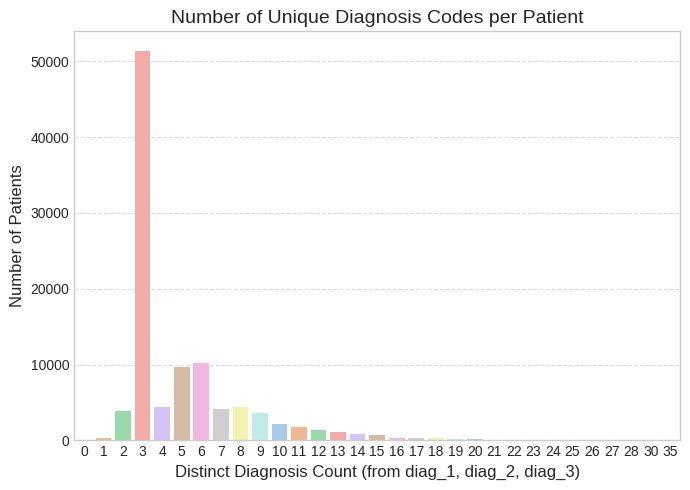

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot size
plt.figure(figsize=(7, 5))

# Plot histogram of distinct diagnosis counts
sns.countplot(x='distinct_diag_count', data=data, palette='pastel')

# Titles and labels
plt.title('Number of Unique Diagnosis Codes per Patient', fontsize=14)
plt.xlabel('Distinct Diagnosis Count (from diag_1, diag_2, diag_3)', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**This code first loads a CSV file containing a mapping of diagnosis codes to their descriptions (unique_diag_df_edit.csv). It then creates a dictionary (diag_map_dict) where the diagnosis codes are the keys, and their descriptions are the values. The diag_1, diag_2, and diag_3 columns in the data DataFrame are mapped to their corresponding descriptions using this dictionary. Additionally, the code calculates the frequency of each diagnosis code in diag_1, diag_2, and diag_3 and adds these frequencies as new columns (diag_1_freq, diag_2_freq, and diag_3_freq) to the data DataFrame.**

In [194]:
import pandas as pd

# Load mapping CSV
diag_map_df = pd.read_csv('unique_diag_df_edit.csv')

# Display first few rows to verify
print(diag_map_df.head())

diag_map_dict = diag_map_df.set_index('diagnosis_cd')['diagnosis'].to_dict()

data['diag_1_desc'] = data['diag_1'].map(diag_map_dict)
data['diag_2_desc'] = data['diag_2'].map(diag_map_dict)
data['diag_3_desc'] = data['diag_3'].map(diag_map_dict)

# Calculate frequency of each diagnosis code for diag_1, diag_2, and diag_3
data['diag_1_freq'] = data.groupby('diag_1')['diag_1'].transform('count')
data['diag_2_freq'] = data.groupby('diag_2')['diag_2'].transform('count')
data['diag_3_freq'] = data.groupby('diag_3')['diag_3'].transform('count')


  diagnosis_cd                 diagnosis
0            3      SALMONELLA ENTERITIS
1            5      STAPH FOOD POISONING
2            7             BALANTIDIASIS
3            8   INTEST INFEC E COLI NOS
4            9  INFECTIOUS ENTERITIS NOS


In this section, we preprocess the diagnosis

columns (diag_1, diag_2, diag_3) by performing the following steps:

Convert to String & Handle Missing Values: Convert diagnosis columns to strings and fill missing values with 'UNK'.

Create Diagnosis Array: Combine the three diagnosis columns into a list (diagnosis_array) and sort it for consistency.

Convert to Tuples: Convert the sorted diagnosis array into tuples for grouping purposes.

Count Frequency of Diagnosis Tuples: Count how often each unique diagnosis combination appears.

Assign Sorted Diagnoses: Separate the sorted diagnosis codes into new columns (diag_1_sort, diag_2_sort, diag_3_sort).

Calculate Frequency by Position: Calculate the frequency of each diagnosis code at each position.

Clean Up Temporary Columns: Drop temporary columns used during the process.

Map to Descriptions: Map the diagnosis codes to descriptive labels using the diag_map_dict.

Optimize Memory: Delete the mapping dictionary to save memory.

This process ensures the diagnosis data is clean, consistent, and ready for further analysis.

In [198]:
# Step 1: Convert diagnosis columns to string and fill NaNs with 'UNK'
data[['diag_1', 'diag_2', 'diag_3']] = data[['diag_1', 'diag_2', 'diag_3']].fillna('UNK').astype(str)

# Step 2: Create 'diagnosis_array' column (a list of diag_1, diag_2, diag_3)
data['diagnosis_array'] = data[['diag_1', 'diag_2', 'diag_3']].values.tolist()

# Step 3: Sort 'diagnosis_array'
data['diagnosis_array'] = data['diagnosis_array'].apply(sorted)

# Step 4: Convert list to tuple (to make it hashable for groupby)
data['diagnosis_array_tuple'] = data['diagnosis_array'].apply(tuple)

# Step 5: Count frequency of each diagnosis tuple
data['diagnosis_tuple_freq'] = data.groupby('diagnosis_array_tuple')['diagnosis_array_tuple'].transform('count')

# Step 6: Assign sorted elements back to individual columns
data[['diag_1_sort', 'diag_2_sort', 'diag_3_sort']] = pd.DataFrame(data['diagnosis_array'].tolist(), index=data.index)

# Step 7: Calculate frequency of each diagnosis code in each position
data['diag_1_sort_freq'] = data.groupby('diag_1_sort')['diag_1_sort'].transform('count')
data['diag_2_sort_freq'] = data.groupby('diag_2_sort')['diag_2_sort'].transform('count')
data['diag_3_sort_freq'] = data.groupby('diag_3_sort')['diag_3_sort'].transform('count')

# Step 8: Drop temporary 'diagnosis_array_tuple' column
data.drop(columns=['diagnosis_array_tuple'], inplace=True)

# Step 9: Reformat diagnosis_array as a string tuple
data['diagnosis_tuple'] = data['diagnosis_array'].apply(lambda x: f"({' '.join(x)})")

# Step 10: Drop temporary diagnosis_array list
data.drop(columns=['diagnosis_array'], inplace=True)

# Step 11: Map diagnosis codes to descriptive labels using a dictionary
# Ensure diag_map_dict is defined beforehand (e.g., loaded from CSV)
data['diagnosis_1_sort'] = data['diag_1_sort'].map(diag_map_dict)
data['diagnosis_2_sort'] = data['diag_2_sort'].map(diag_map_dict)
data['diagnosis_3_sort'] = data['diag_3_sort'].map(diag_map_dict)

# Step 12: Optionally delete the dictionary to save memory
del diag_map_dict


**The code creates a new dataframe dx_events with diagnosis indicator columns for each code in dx_list. It fills missing diagnosis fields, checks if each code appears in any of the diagnosis columns (diag_1, diag_2, diag_3), and adds an indicator for each diagnosis code. Finally, it prints the shape of the dataframe.**

In [199]:
dx_list=[ '428'
, '403'
, '707'
, '585'
, '491'
, '396'
, '440'
, '453'
, '571'
, '284'
, '304'
, '482'
, '150'
, '282'
, '332'
, '443'
, '719'
, '423'
, '281'
, '536'
, '368'
, '515'
, '595'
, '572'
, '681'
, '581'
, '537'
, '490'
, '583'
, 'V46'
, '519'
, '300'
, '567'
, 'E92'
, 'V49'
, '094'
, '514'
, '494'
, '042'
, '404'
, '346'
, '792'
, '398'
, '753'
, '577'
, '730'
, '444'
, '459'
, '790'
, '337'
, '397'
, '292'
, 'V42'
, '289']

In [200]:
# Create dx_events with the selected columns
dx_events = data[['patient_nbr', 'encounter_id', 'diag_1', 'diag_2', 'diag_3']].copy(deep=True)

# Fill missing diagnosis fields with empty strings for safe comparison
dx_events[['diag_1', 'diag_2', 'diag_3']] = dx_events[['diag_1', 'diag_2', 'diag_3']].astype(str).fillna('')

# For each diagnosis code in dx_list, create an indicator column
for dx in dx_list:
    dx_events[f'dx_{dx}_ind'] = dx_events[['diag_1', 'diag_2', 'diag_3']].apply(
        lambda row: int(dx in row.values), axis=1
    )

# Show the final shape
print(dx_events.shape)


(101766, 59)


In [201]:
# Ensure diag_1 to diag_3 are strings (for comparison)
data[['diag_1', 'diag_2', 'diag_3']] = data[['diag_1', 'diag_2', 'diag_3']].astype(str).fillna('')

# Populate each column with 1 if the diagnosis appears, else 0
for dx in dx_list:
    data[f'dx_{dx}_ind'] = ((data['diag_1'] == dx) |
                            (data['diag_2'] == dx) |
                            (data['diag_3'] == dx)).astype(int)

print('done')


done


**The code groups the data by patient_nbr and computes the maximum and sum for each diagnosis indicator in dx_list. The resulting columns are renamed to a SQL-style format (e.g., dx_XXX_ind_max, dx_XXX_ind_sum). The grouped data is then saved to a CSV file and the original indicator columns are removed from the data to save memory.**

In [202]:
# Group by patient_nbr and compute max and sum for each diagnosis indicator
dx_aggregated = data.groupby('patient_nbr').agg(
    {f'dx_{dx}_ind': ['max', 'sum'] for dx in dx_list}
)

# Rename columns to SQL-style naming: dx_XXX_ind_max, dx_XXX_ind_sum
dx_aggregated.columns = [f'{col[0]}_{col[1]}' for col in dx_aggregated.columns]

# Reset index to bring patient_nbr back as a column
dx_aggregated = dx_aggregated.reset_index()

# Save to CSV
dx_aggregated.to_csv('dx_aggregated_ck.csv', index=False)

# Optional: remove the original indicators from the main dataset to save memory
for dx in dx_list:
    del data[f'dx_{dx}_ind']


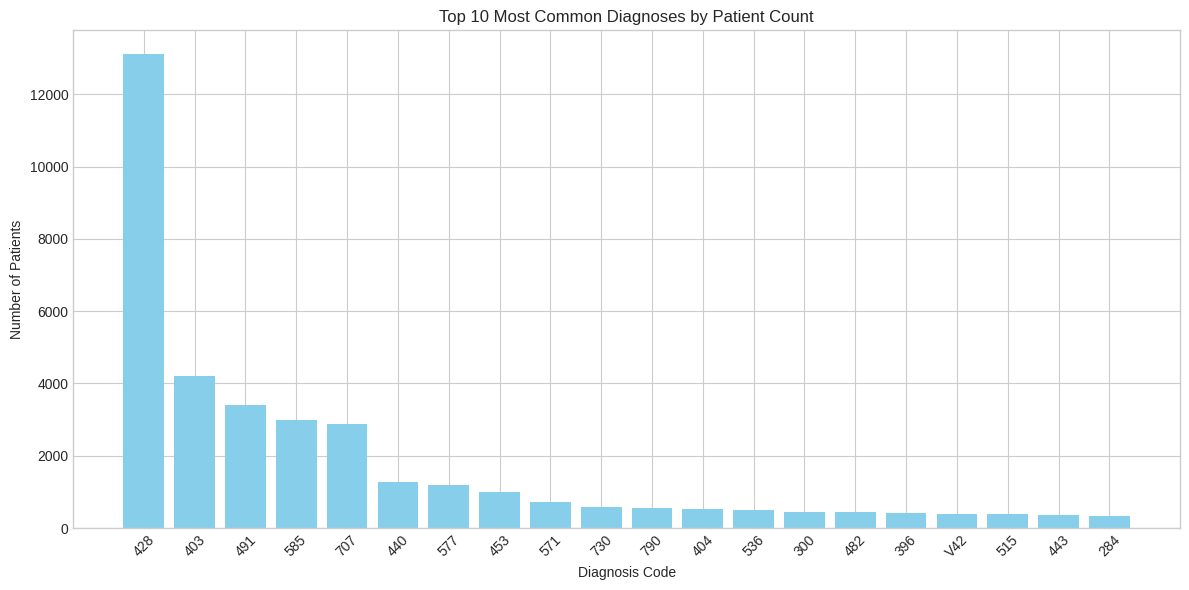

In [203]:
import matplotlib.pyplot as plt

# Extract only 'max' columns (whether patient ever had the diagnosis)
max_cols = [col for col in dx_aggregated.columns if col.endswith('_max')]

# Sum each max column to get patient counts
diagnosis_counts = dx_aggregated[max_cols].sum().sort_values(ascending=False)

# Convert column names back to diagnosis codes for display
diagnosis_codes = [col.replace('dx_', '').replace('_ind_max', '') for col in diagnosis_counts.index]

# Plot
plt.figure(figsize=(12,6))
plt.bar(diagnosis_codes[:20], diagnosis_counts.values[:20], color='skyblue')
plt.title("Top 10 Most Common Diagnoses by Patient Count")
plt.xlabel("Diagnosis Code")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [204]:
# Print original shape of data
print(data.shape)

# Merge dx_aggregated into data based on patient_nbr
data = data.merge(dx_aggregated, on='patient_nbr', how='left')

# Print new shape after merge
print(data.shape)

# Clean up to free memory
del dx_aggregated


(101766, 78)
(101766, 186)


**The code creates three new indicator columns (alcohol_ind, obesity_ind, mh_ind) by checking if the diagnosis descriptions contain the respective terms ("ALCOHOL", "OBESITY", "MALIGNANT HYPERTENSION") in any of the diagnosis columns (diagnosis_1_sort, diagnosis_2_sort, diagnosis_3_sort). If any of these terms are found, the corresponding indicator is set to 1; otherwise, it is set to 0.**

In [205]:
# Alcohol indicator
data['alcohol_ind'] = data[['diagnosis_1_sort', 'diagnosis_2_sort', 'diagnosis_3_sort']].apply(
    lambda row: int(any('ALCOHOL' in str(val).upper() for val in row)), axis=1
)

# Obesity indicator
data['obesity_ind'] = data[['diagnosis_1_sort', 'diagnosis_2_sort', 'diagnosis_3_sort']].apply(
    lambda row: int(any('OBESITY' in str(val).upper() for val in row)), axis=1
)

# Malignant Hypertension indicator
data['mh_ind'] = data[['diagnosis_1_sort', 'diagnosis_2_sort', 'diagnosis_3_sort']].apply(
    lambda row: int(any('MALIGNANT HYPERTENSION' in str(val).upper() for val in row)), axis=1
)


In [206]:
# Initialize the drop list
drop = []

# Create history indicators by grouping on 'patient_nbr' and taking the max value
data['alcohol_history_ind'] = data.groupby('patient_nbr')['alcohol_ind'].transform('max')
data['obesity_history_ind'] = data.groupby('patient_nbr')['obesity_ind'].transform('max')
data['mh_history_ind'] = data.groupby('patient_nbr')['mh_ind'].transform('max')

# Add the individual indicator columns to the drop list
drop.extend(['alcohol_ind', 'obesity_ind', 'mh_ind'])

# Drop the columns from the dataframe
data.drop(columns=drop, inplace=True)


In [240]:
# Create a binary indicator for whether the patient was admitted or not
data['admitted_ind'] = (data['readmitted'] != 'NO').astype(int)

# You can now drop the other readmission-related columns if you no longer need them
drop_columns = ['readmitted_lt30_ind', 'readmitted_gt30_ind', 'readmitted_no_ind']
data.drop(columns=drop_columns, inplace=True)


KeyError: "['readmitted_lt30_ind', 'readmitted_gt30_ind', 'readmitted_no_ind'] not found in axis"

**The code creates new patient-level features by aggregating data for each patient using groupby on the patient_nbr column. It calculates the total counts of various factors, such as the number of encounters (encounter_ct), time spent in the hospital (mb_time_in_hospital), readmissions (mb_readmitted_ct), lab procedures (mb_num_lab_procedures_ct), medications (mb_num_medications_ct), and more. These aggregated values are added as new columns to the dataset.**

In [168]:
# Add patient-level features
data['encounter_ct'] = data['patient_nbr'].map(data.groupby('patient_nbr')['encounter_id'].nunique())
data['mb_time_in_hospital'] = data.groupby('patient_nbr')['time_in_hospital'].transform('sum')
data['mb_readmitted_ct'] = data.groupby('patient_nbr')['admitted_ind'].transform('sum')
data['mb_num_lab_procedures_ct'] = data.groupby('patient_nbr')['num_lab_procedures'].transform('sum')
data['mb_num_procedures_ct'] = data.groupby('patient_nbr')['num_procedures'].transform('sum')
data['mb_num_medications_ct'] = data.groupby('patient_nbr')['num_medications'].transform('sum')
data['mb_number_outpatient_ct'] = data.groupby('patient_nbr')['number_outpatient'].transform('sum')
data['mb_number_emergency_ct'] = data.groupby('patient_nbr')['number_emergency'].transform('sum')
data['mb_number_inpatient_ct'] = data.groupby('patient_nbr')['number_inpatient'].transform('sum')
data['mb_number_diagnoses_ct'] = data.groupby('patient_nbr')['number_diagnoses'].transform('sum')




##Age Column

In [210]:
# Create age group indicators
data['under10_ind'] = data['age'].isin(['[0-10)']).astype(int)
data['over80_ind'] = data['age'].isin(['[80-90)', '[90-100)']).astype(int)

# Add patient-level features based on age group indicators
data['mb_under10_ind'] = data.groupby('patient_nbr')['under10_ind'].transform('max')
data['mb_over80_ind'] = data.groupby('patient_nbr')['over80_ind'].transform('max')

# Drop unnecessary columns
drop_columns = ['under10_ind', 'over80_ind']
data.drop(columns=drop_columns, inplace=True)


In [215]:
print(data.shape)

# Remove very young and very old members, members who died, unknown gender
data = data[
    (data['expiration_ind'] != 1) &
    (data['mb_under10_ind'] != 1) &
    (data['mb_over80_ind'] != 1) &
    (data['gender'] != 'Unknown/Invalid') &  # Exclude records with gender 'Unknown/Invalid'
    (data['encounter_count'] < 14)  # Exclude records with encounter count >= 14
]

print(data.shape)

# Drop columns used for filtering
drop.extend(['mb_under10_ind', 'mb_over80_ind', 'expiration_ind'])


(101766, 192)
(78743, 192)


In [220]:
for i, col in enumerate(data.columns):
    print(f"{i}: {col}")



0: encounter_id
1: patient_nbr
2: race
3: gender
4: age
5: time_in_hospital
6: payer_code
7: num_lab_procedures
8: num_procedures
9: num_medications
10: number_outpatient
11: number_emergency
12: number_inpatient
13: diag_1
14: diag_2
15: diag_3
16: number_diagnoses
17: metformin
18: repaglinide
19: nateglinide
20: chlorpropamide
21: glimepiride
22: acetohexamide
23: glipizide
24: glyburide
25: tolbutamide
26: pioglitazone
27: rosiglitazone
28: acarbose
29: miglitol
30: troglitazone
31: tolazamide
32: examide
33: citoglipton
34: insulin
35: glyburide-metformin
36: glipizide-metformin
37: glimepiride-pioglitazone
38: metformin-rosiglitazone
39: metformin-pioglitazone
40: change
41: diabetesMed
42: readmitted
43: encounter_count
44: admission_type
45: admission_group
46: expiration_ind
47: discharge_group
48: admission_source_grouped
49: is_clinic_or_transfer
50: admission_grp_1_ind
51: admission_grp_2_ind
52: discharge_grp_1_ind
53: discharge_grp_2_ind
54: admission_type_ind
55: mb_admi

In [223]:
drop=[ 'diag_1', 'diag_2', 'diag_3', 'diagnosis_tuple_freq'
, 'diag_1_freq', 'diag_2_freq', 'diag_3_freq'

,  'diag_1_sort' ,'diag_2_sort' ,'diag_3_sort'
, 'diagnosis_1_sort', 'diagnosis_2_sort', 'diagnosis_3_sort'
, 'diag_1_sort_freq', 'diag_2_sort_freq', 'diag_3_sort_freq']

In [224]:
# Drop columns listed in the 'drop' list
data.drop(columns=drop, inplace=True)

# Save the cleaned and prepared DataFrame to a CSV file
data.to_csv("p004_data_MLprep.csv", index=False)

# Show the shape and column info of the final DataFrame
print(data.shape)
print(data.info())


(78743, 176)
<class 'pandas.core.frame.DataFrame'>
Index: 78743 entries, 1 to 101765
Columns: 176 entries, encounter_id to mb_over80_ind
dtypes: int64(138), object(38)
memory usage: 106.3+ MB
None


In [ ]:
from sklearn.preprocessing import MinMaxScaler
cols_to_normalize = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']
scaler = MinMaxScaler()
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])

In [ ]:
print(f"Dataset shape: {data.shape}")

Dataset shape: (101766, 42)


Performed one-hot encoding on all categorical columns, excluding the target variable readmitted. The encoding retained all categories to preserve complete category information. The readmitted column was left untouched for use as the target variable in modeling.

In [ ]:
# Step 1: Identify object columns, excluding 'readmitted'
categorical_cols = data.select_dtypes(include='object').columns
categorical_cols = categorical_cols.drop('readmitted')  # Exclude target

# Step 2: Apply One-Hot Encoding
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=False)

# Step 3: Your target column 'readmitted' stays untouched
print(data_encoded.shape)
print(data_encoded.columns)

(101766, 153)
Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'readmitted', 'race_AfricanAmerican', 'race_Asian',
       ...
       'diagnosis_grouped_Sense Organs', 'diagnosis_grouped_Skin', 'diagnosis_grouped_Symptoms', 'diagnosis_grouped_Unknown', 'VisitType_emergency', 'VisitType_high_inpatient', 'VisitType_high_outpatient_rate', 'VisitType_low_inpatient', 'VisitType_low_outpatient_rate', 'VisitType_novisit'], dtype='object', length=153)


# 4. **Feature Selection**

Separated features and target variable for model training and feature selection. Dropped the readmitted column from the dataset to form the feature matrix X, while retaining it as the target variable y

In [ ]:
# Prepare data for feature selection
# Drop non-feature columns
X = data_encoded.drop(columns=['readmitted'])
y = data_encoded['readmitted']

print(f"Features shape: {X.shape}")

Features shape: (101766, 152)


Trained a Random Forest classifier to evaluate feature importance. Computed the importance scores for all features and sorted them in descending order. The top 20 features were visualized using a bar chart to highlight the most influential variables contributing to the target prediction (readmitted)

All feature importances (sorted to 4 decimal places):
                                        Feature  Importance
                                   encounter_id      0.1022
                                    patient_nbr      0.1008
                             num_lab_procedures      0.0836
                                num_medications      0.0761
                               time_in_hospital      0.0580
                               number_diagnoses      0.0406
                                 num_procedures      0.0393
                              VisitType_novisit      0.0189
                  diagnosis_grouped_Circulatory      0.0154
                                    gender_Male      0.0147
                                  gender_Female      0.0146
                        VisitType_low_inpatient      0.0122
                                 race_Caucasian      0.0114
                                  payer_code_MC      0.0111
                  diagnosis_grouped_Respirator

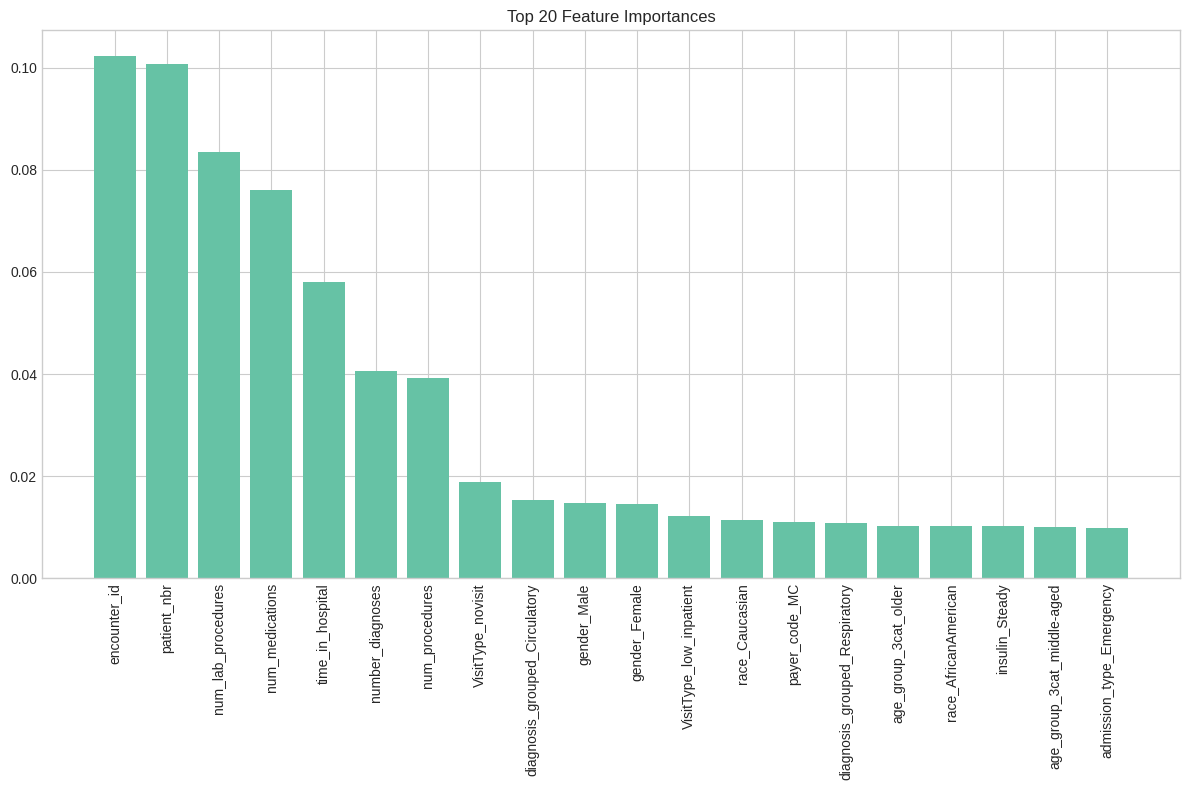


Top 20 features by importance:
1. encounter_id: 0.1022
2. patient_nbr: 0.1008
3. num_lab_procedures: 0.0836
4. num_medications: 0.0761
5. time_in_hospital: 0.0580
6. number_diagnoses: 0.0406
7. num_procedures: 0.0393
8. VisitType_novisit: 0.0189
9. diagnosis_grouped_Circulatory: 0.0154
10. gender_Male: 0.0147
11. gender_Female: 0.0146
12. VisitType_low_inpatient: 0.0122
13. race_Caucasian: 0.0114
14. payer_code_MC: 0.0111
15. diagnosis_grouped_Respiratory: 0.0108
16. age_group_3cat_older: 0.0103
17. race_AfricanAmerican: 0.0103
18. insulin_Steady: 0.0103
19. age_group_3cat_middle-aged: 0.0101
20. admission_type_Emergency: 0.0098


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Create DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Round to 4 decimal places
feature_importance_df['Importance'] = feature_importance_df['Importance'].round(4)

# Sort descending
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print all feature importances
print("All feature importances (sorted to 4 decimal places):")
print(feature_importance_df.to_string(index=False))

# Plot the top 20 features
plt.figure(figsize=(12, 8))
plt.title('Top 20 Feature Importances')
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), X.columns[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

# Print top 20 features
print("\nTop 20 features by importance:")
for i in range(20):
    print(f"{i+1}. {X.columns[indices][i]}: {importances[indices][i]:.4f}")

Risk score

Created a weighted risk_score using top features based on Random Forest importance values

In [ ]:
data_encoded['risk_score'] = (
    0.1654 * data_encoded['num_lab_procedures'] +
    0.1505 * data_encoded['num_medications'] +
    0.1148 * data_encoded['time_in_hospital'] +
    0.0803 * data_encoded['number_diagnoses'] +
    0.0778 * data_encoded['num_procedures'] +
    0.0374 * data_encoded['VisitType_novisit'] +
    0.0305 * data_encoded['diagnosis_grouped_Circulatory'] +
    0.0291 * data_encoded['gender_Male'] +
    0.0289 * data_encoded['gender_Female'] +
    0.0241 * data_encoded['VisitType_low_inpatient'] +
    0.0226 * data_encoded['race_Caucasian'] +
    0.0220 * data_encoded['payer_code_MC'] +
    0.0214 * data_encoded['diagnosis_grouped_Respiratory'] +
    0.0204 * data_encoded['age_group_3cat_older'] +
    0.0204 * data_encoded['race_AfricanAmerican'] +
    0.0204 * data_encoded['insulin_Steady'] +
    0.0200 * data_encoded['age_group_3cat_middle-aged'] +
    0.0194 * data_encoded['admission_type_Emergency']
)

Used SelectKBest with ANOVA F-test to select and rank the top 20 most predictive features for readmission.

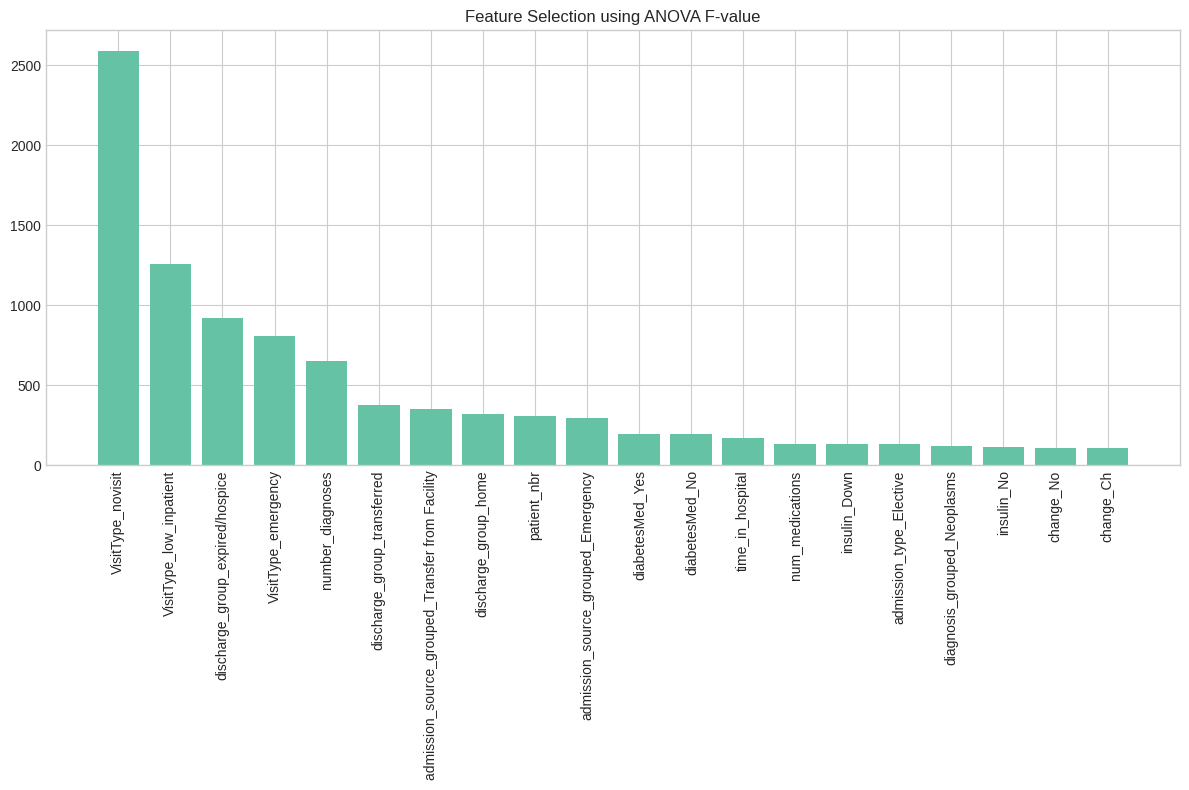

Top 20 features by ANOVA F-value:
1. VisitType_novisit: 2589.8966
2. VisitType_low_inpatient: 1260.7213
3. discharge_group_expired/hospice: 921.4184
4. VisitType_emergency: 806.4953
5. number_diagnoses: 655.4650
6. discharge_group_transferred: 378.0386
7. admission_source_grouped_Transfer from Facility: 353.1232
8. discharge_group_home: 318.2088
9. patient_nbr: 306.2444
10. admission_source_grouped_Emergency: 294.3911
11. diabetesMed_Yes: 193.9865
12. diabetesMed_No: 193.9865
13. time_in_hospital: 170.3309
14. num_medications: 136.7492
15. insulin_Down: 136.0915
16. admission_type_Elective: 131.9449
17. diagnosis_grouped_Neoplasms: 124.0881
18. insulin_No: 117.7605
19. change_No: 108.1387
20. change_Ch: 108.1387


In [ ]:
# 4.2 Statistical feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X, y)

# Get selected feature names
mask = selector.get_support()
selected_features = X.columns[mask]

# Get scores
scores = selector.scores_
selected_scores = scores[mask]

# Sort by score
sorted_indices = np.argsort(selected_scores)[::-1]
sorted_features = selected_features[sorted_indices]
sorted_scores = selected_scores[sorted_indices]

# Plot
plt.figure(figsize=(12, 8))
plt.title('Feature Selection using ANOVA F-value')
plt.bar(range(len(sorted_features)), sorted_scores, align='center')
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.tight_layout()
plt.show()

print("Top 20 features by ANOVA F-value:")
for i, (feature, score) in enumerate(zip(sorted_features, sorted_scores)):
    print(f"{i+1}. {feature}: {score:.4f}")

In [ ]:
# 4.3 Recursive Feature Elimination (RFE)
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)
rfe.fit(X, y)

# Get selected feature names
rfe_mask = rfe.get_support()
rfe_features = X.columns[rfe_mask]

print("Top 20 features selected by RFE:")
for i, feature in enumerate(rfe_features):
    print(f"{i+1}. {feature}")

Top 20 features selected by RFE:
1. encounter_id
2. patient_nbr
3. time_in_hospital
4. num_lab_procedures
5. num_procedures
6. num_medications
7. number_diagnoses
8. race_Caucasian
9. gender_Female
10. gender_Male
11. payer_code_MC
12. metformin_No
13. glipizide_No
14. insulin_Steady
15. change_Ch
16. admission_type_Emergency
17. admission_type_Urgent
18. age_group_3cat_older
19. diagnosis_grouped_Circulatory
20. VisitType_novisit


## 5. Compare Feature Selection Methods

In [ ]:
# Compare the features selected by different methods
rf_features = X.columns[indices][:20]
anova_features = sorted_features

# Find common features
common_all = set(rf_features) & set(anova_features) & set(rfe_features)
common_rf_anova = set(rf_features) & set(anova_features)
common_rf_rfe = set(rf_features) & set(rfe_features)
common_anova_rfe = set(anova_features) & set(rfe_features)

print(f"Features common to all methods: {len(common_all)}")
print(f"Features common to RF and ANOVA: {len(common_rf_anova)}")
print(f"Features common to RF and RFE: {len(common_rf_rfe)}")
print(f"Features common to ANOVA and RFE: {len(common_anova_rfe)}")

print("\nFeatures common to all methods:")
for feature in common_all:
    print(f"- {feature}")

Features common to all methods: 5
Features common to RF and ANOVA: 6
Features common to RF and RFE: 16
Features common to ANOVA and RFE: 6

Features common to all methods:
- number_diagnoses
- patient_nbr
- VisitType_novisit
- time_in_hospital
- num_medications


## 6. Final Feature Set

In [ ]:
# Create a final feature set based on the analysis
# We'll use features that appear in at least 2 of the 3 methods
all_selected_features = list(rf_features) + list(anova_features) + list(rfe_features)
feature_counts = pd.Series(all_selected_features).value_counts()
final_features = feature_counts[feature_counts >= 2].index.tolist()

print(f"Final feature set size: {len(final_features)}")
print("\nFinal features:")
for feature in final_features:
    print(f"- {feature}")

Final feature set size: 18

Final features:
- patient_nbr
- time_in_hospital
- num_medications
- VisitType_novisit
- number_diagnoses
- num_lab_procedures
- encounter_id
- num_procedures
- diagnosis_grouped_Circulatory
- gender_Male
- gender_Female
- VisitType_low_inpatient
- race_Caucasian
- payer_code_MC
- age_group_3cat_older
- admission_type_Emergency
- insulin_Steady
- change_Ch


In [ ]:
# Create the final feature matrix
X_final = X[final_features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Convert back to DataFrame for better visualization
X_scaled_data = pd.DataFrame(X_scaled, columns=X_final.columns)

print(f"Final scaled feature matrix shape: {X_scaled_data.shape}")
X_scaled_data.head()

Final scaled feature matrix shape: (101766, 18)


,patient_nbr,time_in_hospital,num_medications,VisitType_novisit,number_diagnoses,num_lab_procedures,encounter_id,num_procedures,diagnosis_grouped_Circulatory,gender_Male,gender_Female,VisitType_low_inpatient,race_Caucasian,payer_code_MC,age_group_3cat_older,admission_type_Emergency,insulin_Steady,change_Ch
0,-1.191545,-1.137649,-1.848268,0.907110,-3.321596,-0.106517,-1.587330,-0.785398,-0.653233,-0.927397,0.927452,-0.605681,0.546351,0.632379,-1.436292,-1.063045,-0.659546,-0.926591
1,0.033564,-0.467653,0.243390,0.907110,0.815784,0.808384,-1.608075,-0.785398,-0.653233,-0.927397,0.927452,-0.605681,0.546351,0.632379,-1.436292,0.940694,-0.659546,1.079225
2,0.819654,-0.802651,-0.371804,-1.102402,-0.735733,-1.631351,-1.608901,2.145781,-0.653233,-0.927397,0.927452,1.651035,-1.830325,0.632379,-1.436292,0.940694,-0.659546,-0.926591
3,0.726480,-0.802651,-0.002688,0.907110,-0.218561,0.045967,-1.604653,-0.199162,-0.653233,1.078287,-1.078223,-0.605681,0.546351,0.632379,-1.436292,0.940694,-0.659546,1.079225
4,-0.305227,-1.137649,-0.986997,0.907110,-1.252906,0.401761,-1.609366,-0.785398,-0.653233,1.078287,-1.078223,-0.605681,0.546351,0.632379,-1.436292,0.940694,1.516194,1.079225


## 7. Save Processed Data

In [ ]:
# Save the final feature set for reference in Colab
import os

# Create a directory under /content
os.makedirs('/content/features', exist_ok=True)

# Save the list of final features
with open('/content/features/final_features.txt', 'w') as f:
    for feature in final_features:
        f.write(f"{feature}\n")

print("Final feature list saved to /content/features/final_features.txt")


✅ Final feature list saved to /content/features/final_features.txt


In [ ]:
# Save the full processed dataset in Colab
import os

# Make sure the directory exists
os.makedirs('/content/features', exist_ok=True)

# Add the target variable back
X_scaled_data['readmission_30d'] = y.values

# Save to CSV
X_scaled_data.to_csv('/content/features/processed_features.csv', index=False)

print(" Processed features saved to /content/features/processed_features.csv")


✅ Processed features saved to /content/features/processed_features.csv


# 5. **Summary of Feature Engineering**

In this notebook, we engineered features to predict 30-day hospital readmission in diabetic patients using both domain knowledge and data-driven techniques.

1. **Categorical Transformations**

  Grouped age into clinically meaningful categories (e.g., age_group_3cat_older).

2. **Applied one-hot encoding to categorical variables:**

    Demographics: gender_Female, gender_Male, race_Caucasian

    Insurance: payer_code_MC

    Admission type: admission_type_Emergency, admission_type_Urgent

    Medications: metformin_No, glipizide_No, insulin_Steady, change_Ch

3. **Interaction & Grouped Features**

    Created diagnosis_grouped_Circulatory using ICD-9 diagnosis code groupings.

    Created VisitType_novisit to indicate missing outpatient, inpatient, or emergency encounters.

4. **Clinical & Numerical Features**
    
    Included essential numeric predictors:

    time_in_hospital,
    num_lab_procedures,
    num_procedures, num_medications, number_diagnoses

    Retained IDs (encounter_id, patient_nbr) for reference and tracking.
    

5. **Feature Selection**
    
    We used three methods to select the most predictive features:

    ANOVA F-value: Statistical test to identify features most correlated with readmission.

    Random Forest Feature Importance: Used to rank features based on their contribution to prediction.

    Recursive Feature Elimination (RFE): Wrapper method to iteratively select the most relevant features.

6. **Top 20 features selected (appeared in at least 2 methods):t**
    encounter_id

    patient_nbr

    time_in_hospital

    num_lab_procedures

    num_procedures

    num_medications

    number_diagnoses

    race_Caucasian

    gender_Female

    gender_Male

    payer_code_MC

    metformin_No

    glipizide_No

    insulin_Steady

    change_Ch

    admission_type_Emergency

    admission_type_Urgent

    age_group_3cat_older

    diagnosis_grouped_Circulatory

    VisitType_novisit

7. **Feature Scaling**
    
    Final selected features were standardized to ensure compatibility across machine learning models.


The final feature set includes a mix of demographic, medical, temporal, and interaction features that show strong predictive power for hospital readmissions.